In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


Reproduced with code from this excellent [blog](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
tf.__version__

'2.2.0'

### Load data from .csv file

* `train-images-boxable.csv` file contains the image name and image url
* `train-annotations-bbox.csv` file contains the bounding box info with the image id (name) and the image label name
* `class-descriptions-boxable.csv` file contains the image label name corresponding to its class name

Download link:

https://storage.googleapis.com/openimages/web/download.html

https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/

In [ ]:
!wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv

--2020-07-15 06:59:02--  https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1194033454 (1.1G) [text/csv]
Saving to: ‘train-annotations-bbox.csv’

train-annotations-b 100%[===================>]   1.11G   120MB/s    in 9.3s    

2020-07-15 06:59:11 (123 MB/s) - ‘train-annotations-bbox.csv’ saved [1194033454/1194033454]



In [ ]:
!wget https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv

--2020-07-15 06:59:13--  https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638407721 (609M) [text/csv]
Saving to: ‘train-images-boxable-with-rotation.csv’

train-images-boxabl 100%[===================>] 608.83M   198MB/s    in 3.3s    

2020-07-15 06:59:17 (184 MB/s) - ‘train-images-boxable-with-rotation.csv’ saved [638407721/638407721]



The original code used "***train-images-boxable.csv***" but I couldn't find it. So, I am using "***train-images-boxable-with-rotations.csv"***

In [ ]:
!wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv

--2020-07-15 06:59:22--  https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12011 (12K) [text/csv]
Saving to: ‘class-descriptions-boxable.csv’

class-descriptions- 100%[===================>]  11.73K  --.-KB/s    in 0s      

2020-07-15 06:59:22 (85.8 MB/s) - ‘class-descriptions-boxable.csv’ saved [12011/12011]



In [ ]:
images_boxable_fname = 'train-images-boxable-with-rotation.csv'
annotations_bbox_fname = 'train-annotations-bbox.csv'
class_descriptions_fname = 'class-descriptions-boxable.csv'

In [ ]:
images_boxable = pd.read_csv(images_boxable_fname)
images_boxable.head()

ImageID  ... Rotation
0  4fa8054781a4c382  ...      0.0
1  b37f763ae67d0888  ...      0.0
2  7e8584b0f487cb9e  ...      0.0
3  86638230febe21c4  ...      NaN
4  249086e72671397d  ...      0.0

[5 rows x 12 columns]

In [ ]:
annotations_bbox = pd.read_csv(annotations_bbox_fname)
annotations_bbox.head()

ImageID  Source  LabelName  ...  IsGroupOf  IsDepiction  IsInside
0  000002b66c9c498e  xclick  /m/01g317  ...          0            0         0
1  000002b66c9c498e  xclick  /m/01g317  ...          0            0         0
2  000002b66c9c498e  xclick  /m/01g317  ...          0            0         0
3  000002b66c9c498e  xclick  /m/01g317  ...          0            0         0
4  000002b66c9c498e  xclick  /m/01g317  ...          0            0         0

[5 rows x 13 columns]

1. **XMin, XMax, YMin, YMax**: coordinates of the box, in normalized image coordinates.
2. **IsOccluded**: Indicates that the object is occluded by another object in the image.
3. **IsTruncated**: Indicates that the object extends beyond the boundary of the image.
4. **IsGroupOf**: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
5. **IsDepiction**: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
6. **IsInside**: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).


In [ ]:
class_descriptions = pd.read_csv(class_descriptions_fname, header=None)
class_descriptions.head()

0           1
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

### Plot Bounding box

In [ ]:
def plot_bbox(img_id):
  img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

Finding images with lesser number of objects so as easy to visualize

In [ ]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

Image: (2592, 1944, 3)
Coordinates: (435, 529), (1684, 1600)


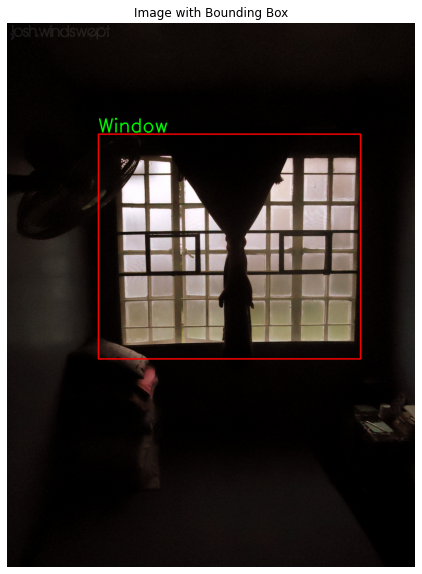

Image: (2848, 4288, 3)
Coordinates: (0, 0), (4285, 627)


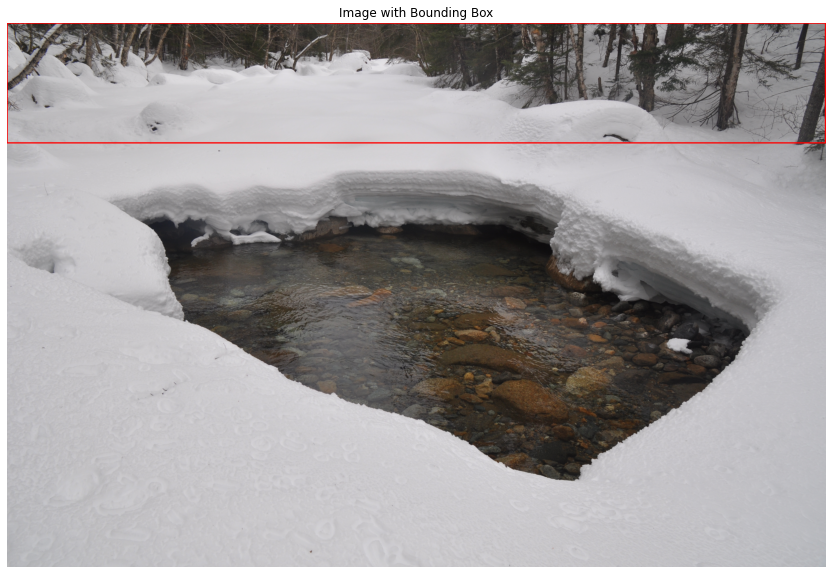

Image: (1470, 2010, 3)
Coordinates: (538, 503), (1700, 1176)


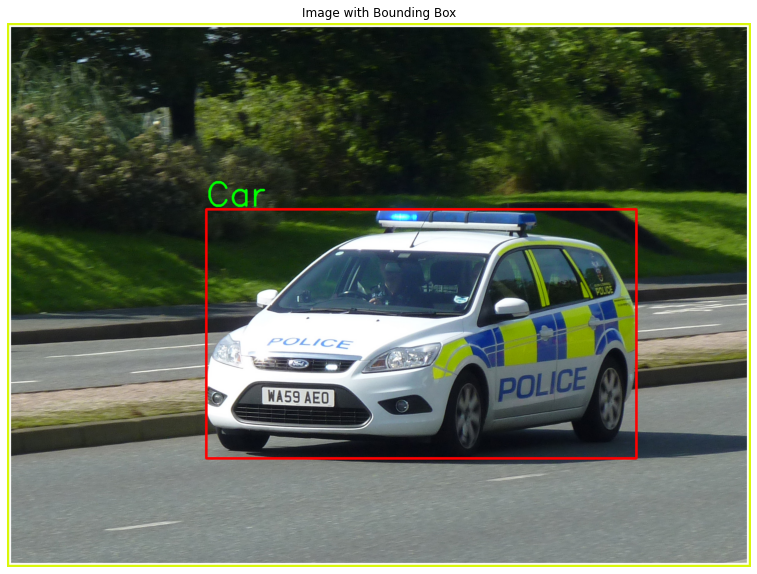

Image: (2304, 3456, 3)
Coordinates: (0, 0), (3453, 2301)


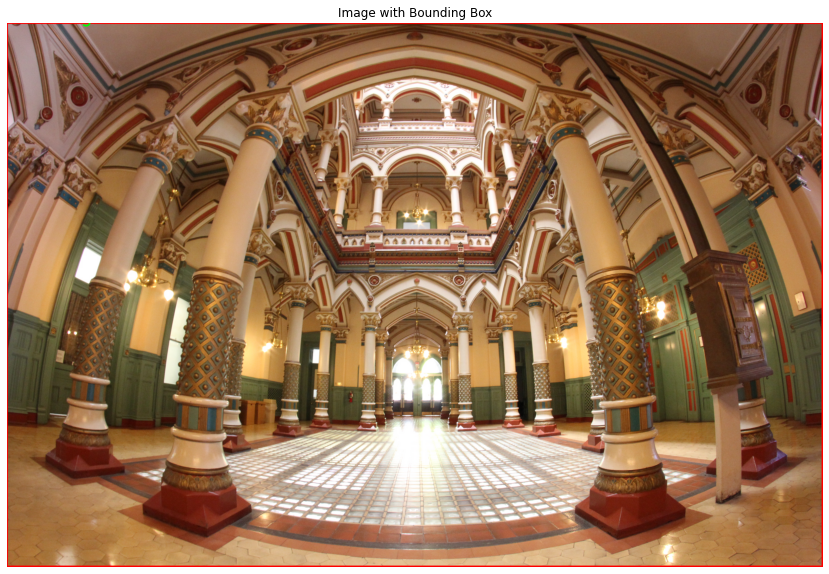

Image: (2112, 2816, 3)
Coordinates: (587, 130), (2319, 1650)


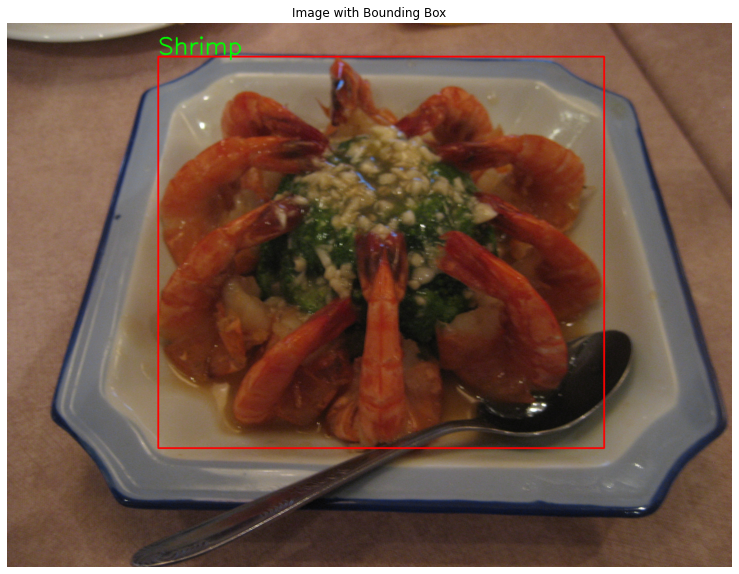

In [ ]:
for img_id in random.sample(list(least_objects_img_ids), 5):
  plot_bbox(img_id)

### Get subset of the whole dataset

For here, I just want to detect three classes, which include person, mobile phone and car. We just extract 1000 images for each class from the whole dataset.

In [ ]:
class_descriptions.loc[class_descriptions[1].isin(['Person', 'Mobile phone', 'Car'])]

0             1
68   /m/01g317        Person
312   /m/050k8  Mobile phone
570    /m/0k4j           Car

In [ ]:
# Find the label_name for 'Person', 'Mobile Phone' and 'Car' classes
person_pd = class_descriptions[class_descriptions[1]=='Person']
phone_pd = class_descriptions[class_descriptions[1]=='Mobile phone']
car_pd = class_descriptions[class_descriptions[1]=='Car']

label_name_person = person_pd[0].values[0]
label_name_phone = phone_pd[0].values[0]
label_name_car = car_pd[0].values[0]

**Be careful that there might be several object in one image. For example, there are three person and two mobile phone in one image**

In [ ]:
person_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_person]
phone_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_phone]
car_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_car]

In [ ]:
print('There are %d persons in the dataset' %(len(person_bbox)))
print('There are %d phones in the dataset' %(len(phone_bbox)))
print('There are %d cars in the dataset' %(len(car_bbox)))
person_img_id = person_bbox['ImageID']
phone_img_id = phone_bbox['ImageID']
car_img_id = car_bbox['ImageID']

There are 1034721 persons in the dataset
There are 6365 phones in the dataset
There are 248075 cars in the dataset


In [ ]:
person_img_id = np.unique(person_img_id)
phone_img_id = np.unique(phone_img_id)
car_img_id = np.unique(car_img_id)
print('There are %d images which contain persons' % (len(person_img_id)))
print('There are %d images which contain phones' % (len(phone_img_id)))
print('There are %d images which contain cars' % (len(car_img_id)))

There are 248384 images which contain persons
There are 4312 images which contain phones
There are 89465 images which contain cars


We just randomly pick 1000 images in here.

In [ ]:
# here I've chosen only 10 images for speed
# For training I took 1000 images in each class.
n = 10
subperson_img_id = random.sample(list(person_img_id), n)
subphone_img_id = random.sample(list(phone_img_id), n)
subcar_img_id = random.sample(list(car_img_id), n)

In [ ]:
subperson_pd = images_boxable.loc[images_boxable['ImageID'].isin(subperson_img_id)]
subphone_pd = images_boxable.loc[images_boxable['ImageID'].isin(subphone_img_id)]
subcar_pd = images_boxable.loc[images_boxable['ImageID'].isin(subcar_img_id)]

In [ ]:
subperson_pd.shape

(10, 12)

In [ ]:
subperson_pd.head()

ImageID  ... Rotation
76568   ab8bd6bef86d0b78  ...      NaN
207833  7637b759a60f8921  ...      0.0
210355  aa2f85b3133201b5  ...      0.0
476039  6f0277f614a9f9ec  ...      0.0
489446  1832bd9d7044509e  ...      0.0

[5 rows x 12 columns]

In [ ]:
subperson_dict = subperson_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subphone_dict = subphone_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subcar_dict = subcar_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()

In [ ]:
# subperson_img_url = subperson_pd['OriginalURL'].tolist()
# subphone_img_url = subphone_pd['OriginalURL'].tolist()
# subcar_img_url = subcar_pd['OriginalURL'].tolist()

In [ ]:
mappings = [subperson_dict, subphone_dict, subcar_dict]

In [ ]:
len(mappings)

3

In [ ]:
len(mappings[0])

10

In [ ]:
classes = ['Person', 'Mobile phone', 'Car']

### Download images

We need to save the images with filename as `image id` with jpg extension

In [ ]:
# download images
for idx, obj_type in enumerate(classes):
  n_issues = 0
  # create the directory
  if not os.path.exists(obj_type):
    os.mkdir(obj_type)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(obj_type, img_id+".jpg")
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 0
Images Issues: 1
Images Issues: 1


In [ ]:
!ls Person | wc -l

10


In [ ]:
!ls Mobile\ phone | wc -l

9


In [ ]:
!ls Car | wc -l

9


### Dataset format for Faster-RCNN code

(fname_path, xmin, xmax, ymin, ymax, class_name)

train: 0.8
validation: 0.2

In [ ]:
# save images to train and test directory
train_path = 'train'
test_path = 'test'

In [ ]:
!mkdir train test

In [ ]:
random.seed(1)

In [ ]:
for i in range(len(classes)):
    all_imgs = os.listdir(classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n*0.8)

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]
    
    # copy each classes' images to train directory
    for j in range(len(train_imgs)):
        original_path = os.path.join(classes[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    
    # copy each classes' images to test directory
    for j in range(len(test_imgs)):
        original_path = os.path.join(classes[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

In [ ]:
!ls train | wc -l

24


In [ ]:
!ls test | wc -l

4


The expected number of training images and validation images should be 24 and 6 respectively.

However, there might be some overlap images which appear in two or three classes simultaneously. For instance, an image might be a person walking on the street and there are several cars in the street

In [ ]:
label_names = [label_name_person, label_name_phone, label_name_car]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [ ]:
train_df.head()

FileName      XMin      XMax      YMin      YMax ClassName
0  fd81e75926e65990.jpg  0.585366  0.668543  0.339641  0.749004    Person
1  fd81e75926e65990.jpg  0.105066  0.186366  0.447211  0.745020    Person
2  fd81e75926e65990.jpg  0.208881  0.283302  0.406375  0.750996    Person
3  fd81e75926e65990.jpg  0.343965  0.375860  0.437251  0.517928    Person
4  fd81e75926e65990.jpg  0.375860  0.429644  0.404382  0.743028    Person

In [ ]:
train_df.shape

(125, 6)

Let's test if they work fine by plotting the bounding box for the above 5 images

In [ ]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique()

Image: (1595, 2541, 3)
Coordinates: (1487, 541), (1698, 1194)
Coordinates: (266, 713), (473, 1188)
Coordinates: (530, 648), (719, 1197)
Coordinates: (874, 697), (955, 826)
Coordinates: (955, 644), (1091, 1185)
Coordinates: (1061, 657), (1231, 1213)
Coordinates: (1365, 735), (1449, 830)
Coordinates: (1390, 865), (1533, 1139)
Coordinates: (1746, 703), (1873, 1058)
Coordinates: (2067, 745), (2200, 959)
Coordinates: (2318, 689), (2498, 1083)


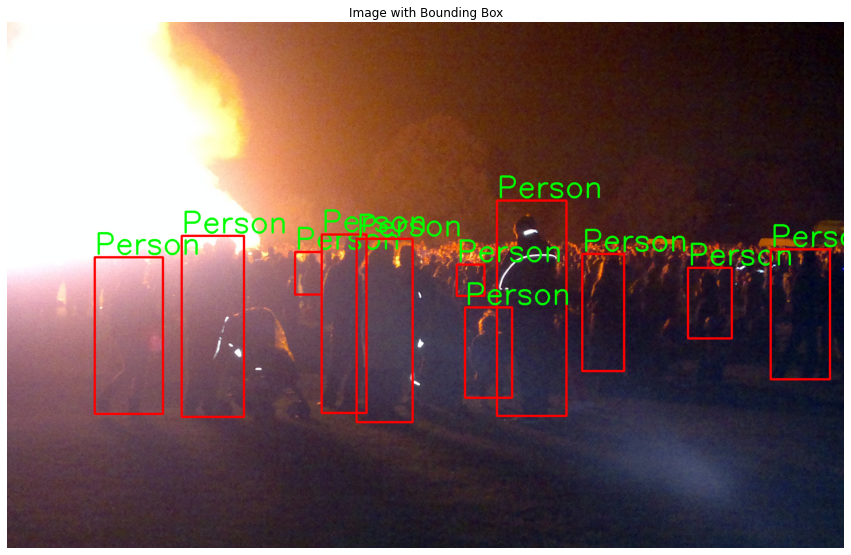

In [ ]:
for img_id in train_img_ids:
  plot_bbox(img_id)

**This looks fine to me!!**

In [ ]:
test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                test_df = test_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [ ]:
test_df.head()

FileName      XMin      XMax      YMin      YMax     ClassName
0  aa2f85b3133201b5.jpg  0.555000  0.896875  0.114447  1.000000        Person
1  aa2f85b3133201b5.jpg  0.240625  0.345625  0.106942  0.275797        Person
2  aa2f85b3133201b5.jpg  0.560000  0.594375  0.189493  0.237336        Person
3  6f0277f614a9f9ec.jpg  0.236250  0.703750  0.122500  0.889167        Person
4  ebd331ed45986b8b.jpg  0.077500  0.875625  0.355833  0.699167  Mobile phone

In [ ]:
test_df.shape

(6, 6)

In [ ]:
test_img_ids = train_df["FileName"].head().str.split(".").str[0].unique()

Image: (1595, 2541, 3)
Coordinates: (1487, 541), (1698, 1194)
Coordinates: (266, 713), (473, 1188)
Coordinates: (530, 648), (719, 1197)
Coordinates: (874, 697), (955, 826)
Coordinates: (955, 644), (1091, 1185)
Coordinates: (1061, 657), (1231, 1213)
Coordinates: (1365, 735), (1449, 830)
Coordinates: (1390, 865), (1533, 1139)
Coordinates: (1746, 703), (1873, 1058)
Coordinates: (2067, 745), (2200, 959)
Coordinates: (2318, 689), (2498, 1083)


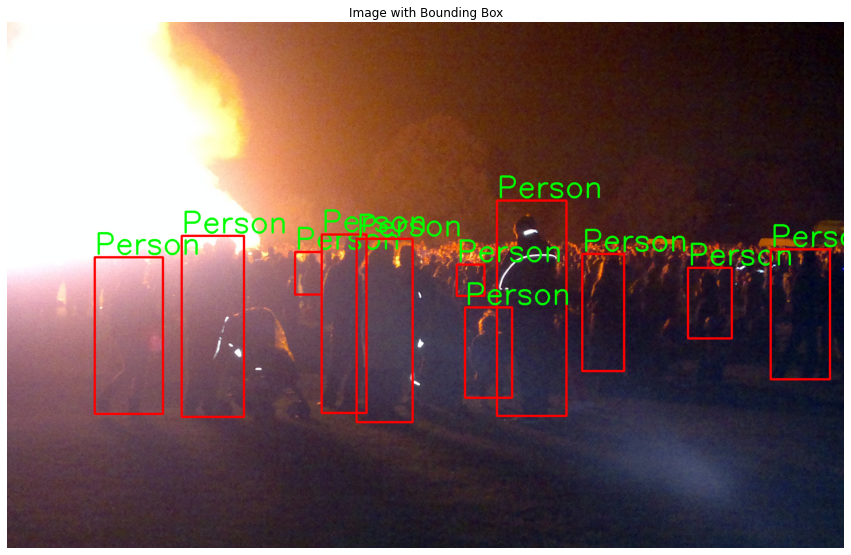

In [ ]:
for img_id in test_img_ids:
  plot_bbox(img_id)

In [ ]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

### Write train.csv to annotation.txt

In [ ]:
train_df = pd.read_csv('train.csv')

# for training
with open("annotation.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      img = cv2.imread('train/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      google_colab_file_path = 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/train'
      fileName = os.path.join(google_colab_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [ ]:
test_df = pd.read_csv('test.csv')

# for test
with open("test_annotation.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread('test/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      google_colab_file_path = 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/test'
      fileName = os.path.join(google_colab_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

Run these cells if needed to recreate the dataset or else skip it

In [ ]:
!mv train 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/train'
!mv test 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/test'

In [ ]:
!mv annotation.txt 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/annotation.txt'
!mv test_annotation.txt 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/test_annotation.txt'